### Set-up

In [17]:
# Imports
import numpy as np
from numpy import concatenate
from pandas import read_csv, DataFrame, concat
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [39]:
# Define global variables
num_features = 53
target_variable = 'POILBRE'
lag_steps = 1

In [40]:
df = read_csv('dataset.csv', header = 0, index_col = 0, usecols = [i for i in range(0, num_features+1)])
df.dropna(inplace=True) # NA values after June 2017
print(df.shape)
df.head()

(294, 53)


,PALUM,PBANSOP,PBARL,PBEEF,PCOALAU,PCOCO,PCOFFOTM,PCOFFROB,PROIL,PCOPP,...,PSUGAISA,PSUGAUSA,PSUNO,PTEA,PTIN,PURAN,PWHEAMT,PWOOLC,PWOOLF,PZINC
Commodity,,,,,,,,,,,,,,,,,,,,,
1993M1,1208.10,524.92,75.08,106.80,35.0,1035.57,68.66,48.13,425.93,2264.21,...,8.24,20.76,582.52,239.49,5913.10,9.80,155.65,312.39,495.22,1067.57
1993M2,1203.15,585.61,74.83,108.32,31.0,990.99,67.46,48.25,419.78,2212.18,...,8.56,21.05,570.79,203.56,5792.75,10.10,148.88,309.68,469.37,1073.63
1993M3,1150.48,659.00,75.16,114.59,31.0,977.32,62.77,46.86,435.22,2152.38,...,10.62,21.57,574.59,190.48,5666.30,10.20,147.90,309.67,469.37,996.76
1993M4,1110.28,563.70,77.45,117.57,31.0,1010.75,56.88,45.51,454.70,1953.62,...,11.15,21.69,607.14,177.75,5596.50,10.35,141.99,328.92,429.69,1006.00
1993M5,1125.42,461.60,77.46,121.39,31.0,998.07,61.48,46.91,436.65,1799.35,...,11.83,21.36,640.15,172.86,5505.47,10.10,136.58,337.01,468.13,979.26


In [41]:
df.tail()

,PALUM,PBANSOP,PBARL,PBEEF,PCOALAU,PCOCO,PCOFFOTM,PCOFFROB,PROIL,PCOPP,...,PSUGAISA,PSUGAUSA,PSUNO,PTEA,PTIN,PURAN,PWHEAMT,PWOOLC,PWOOLF,PZINC
Commodity,,,,,,,,,,,,,,,,,,,,,
2017M2,1860.75,1040.10,136.23,184.60,85.97,2034.08,165.56,110.13,872.33,5940.91,...,20.35,30.40,966.97,382.87,19446.48,25.06,147.31,1029.58,1368.14,2845.55
2017M3,1901.47,1075.25,137.29,190.17,86.33,2063.09,159.39,110.02,839.92,5824.63,...,18.06,29.83,936.78,356.10,19875.20,24.55,146.39,1059.60,1454.83,2776.88
2017M4,1921.22,1063.54,138.80,192.88,90.11,1961.16,155.90,106.25,823.03,5683.90,...,16.40,28.72,939.95,362.10,19910.32,23.17,138.41,991.12,1404.98,2614.92
2017M5,1913.02,1083.05,142.08,200.41,80.12,1983.48,151.18,101.47,833.63,5599.56,...,15.69,28.43,949.83,371.48,20200.33,21.56,146.49,1019.95,1433.47,2590.21
2017M6,1885.29,1098.07,140.80,206.16,85.67,1998.25,144.10,104.83,830.44,5719.76,...,13.75,27.83,936.24,381.22,19658.84,19.68,157.20,1065.81,1403.83,2573.40


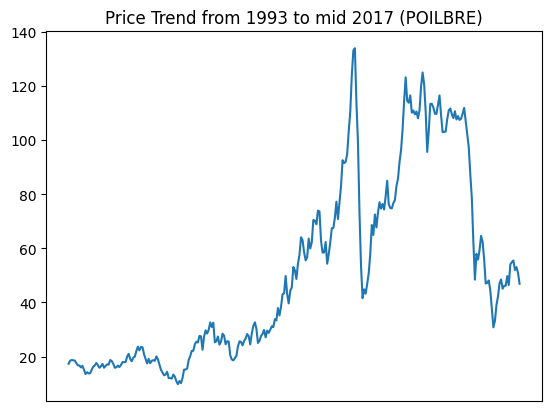

In [42]:
poilbre_line_plot = plt.plot(df.index, df[target_variable])
plot_gca = plt.gca()
plot_gca.set_title('Price Trend from 1993 to mid 2017 (POILBRE)')
plot_gca.axes.get_xaxis().set_ticks([])
plt.show()

### Transformation

In [44]:
# Transform the time-series dataset specifically for LSTM
def time_series_to_lstm(df, target_variable, lag_steps=1, dropna=True, fill='ffill'):
    """
    Transforms time-series data into a supervised learning format compatible with LSTMs.
    
    Args:
        df (pd.DataFrame): The input time-series dataset.
        target_variable (str): The column to predict.
        lag_steps (int): Number of past time steps to include.
        dropna (bool): Whether to drop rows with NaN values.
        fill (str): What to fill NaN values with ('ffill', 'bfill', 'mean', 'median', None)
        
    Returns:
        X (np.array): Feature set shaped for LSTM (samples, time steps, features).
        y (np.array): Target variable for each sample.
    """
    # Ensure dataframe format
    if isinstance(df, list):
        df = DataFrame(df)
    
    cols = []
    feature_names = []
    
    # Create Lag Steps
    for i in range(lag_steps, 0, -1):
        cols.append(df.shift(i))
        feature_names += [f"{col}(t-{i})" for col in df.columns]
    
    # Current time step (t) for target variable
    cols.append(df[[target_variable]])
    feature_names += [f"{target_variable}(t)"]
    
    # Combine and assign column names
    df_transformed = concat(cols, axis=1)
    df_transformed.columns = feature_names
    
    # Drop NaN rows if required
    if dropna:
        df_transformed.dropna(inplace=True)
    else:
        if not None:
            df_transformed.fillna(method=fill, inplace=True)
    
    return df_transformed


In [45]:
df_transformed = time_series_to_lstm(df, target_variable, lag_steps)
print(df_transformed.shape)
df_transformed.head()

(293, 54)


,PALUM(t-1),PBANSOP(t-1),PBARL(t-1),PBEEF(t-1),PCOALAU(t-1),PCOCO(t-1),PCOFFOTM(t-1),PCOFFROB(t-1),PROIL(t-1),PCOPP(t-1),...,PSUGAUSA(t-1),PSUNO(t-1),PTEA(t-1),PTIN(t-1),PURAN(t-1),PWHEAMT(t-1),PWOOLC(t-1),PWOOLF(t-1),PZINC(t-1),POILBRE(t)
Commodity,,,,,,,,,,,,,,,,,,,,,
1993M2,1208.10,524.92,75.08,106.80,35.0,1035.57,68.66,48.13,425.93,2264.21,...,20.76,582.52,239.49,5913.10,9.80,155.65,312.39,495.22,1067.57,18.48
1993M3,1203.15,585.61,74.83,108.32,31.0,990.99,67.46,48.25,419.78,2212.18,...,21.05,570.79,203.56,5792.75,10.10,148.88,309.68,469.37,1073.63,18.75
1993M4,1150.48,659.00,75.16,114.59,31.0,977.32,62.77,46.86,435.22,2152.38,...,21.57,574.59,190.48,5666.30,10.20,147.90,309.67,469.37,996.76,18.63
1993M5,1110.28,563.70,77.45,117.57,31.0,1010.75,56.88,45.51,454.70,1953.62,...,21.69,607.14,177.75,5596.50,10.35,141.99,328.92,429.69,1006.00,18.51
1993M6,1125.42,461.60,77.46,121.39,31.0,998.07,61.48,46.91,436.65,1799.35,...,21.36,640.15,172.86,5505.47,10.10,136.58,337.01,468.13,979.26,17.59


In [54]:
# Train-Test Split
split = int(df_transformed.shape[0]*0.8)
train = df_transformed[:split]
test = df_transformed[split:]

print('Split Shape:', train.shape, test.shape)

Split Shape: (234, 54) (59, 54)


In [67]:
# Scale to avoid distance calculation bias
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test) # Avoid data leakage

In [66]:
train.iloc[:, -1]

Commodity
1993M2     18.48
1993M3     18.75
1993M4     18.63
1993M5     18.51
1993M6     17.59
           ...  
2012M3    124.93
2012M4    120.59
2012M5    110.52
2012M6     95.59
2012M7    103.14
Name: POILBRE(t), Length: 234, dtype: float64

In [76]:
# Separate into features and target (last column)
X_train, y_train = train_scaled[:, :-1], train_scaled[:, -1]
X_test, y_test = test_scaled[:, :-1], test_scaled[:, -1]

In [77]:
# Reshape features for LSTM
X_train = X_train.reshape((X_train.shape[0], lag_steps, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], lag_steps, X_test.shape[1]))

print('Train Shape:', X_train.shape, y_train.shape)
print('Test Shape:', X_test.shape, y_test.shape)


Train Shape: (234, 1, 53) (234,)
Test Shape: (59, 1, 53) (59,)


### LSTM Training

In [115]:
# Initiate LSTM model
model = Sequential()
model.add(LSTM(125, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

/Users/xaviersan/.pyenv/versions/brent/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/70
2/2 - 1s - 394ms/step - loss: 0.2946 - val_loss: 0.4401
Epoch 2/70
2/2 - 0s - 22ms/step - loss: 0.1715 - val_loss: 0.2447
Epoch 3/70
2/2 - 0s - 22ms/step - loss: 0.1145 - val_loss: 0.1406
Epoch 4/70
2/2 - 0s - 21ms/step - loss: 0.0941 - val_loss: 0.1305
Epoch 5/70
2/2 - 0s - 22ms/step - loss: 0.1159 - val_loss: 0.1361
Epoch 6/70
2/2 - 0s - 22ms/step - loss: 0.1323 - val_loss: 0.1335
Epoch 7/70
2/2 - 0s - 22ms/step - loss: 0.1170 - val_loss: 0.1228
Epoch 8/70
2/2 - 0s - 22ms/step - loss: 0.0943 - val_loss: 0.1220
Epoch 9/70
2/2 - 0s - 22ms/step - loss: 0.0847 - val_loss: 0.1235
Epoch 10/70
2/2 - 0s - 22ms/step - loss: 0.0813 - val_loss: 0.1230
Epoch 11/70
2/2 - 0s - 22ms/step - loss: 0.0753 - val_loss: 0.1180
Epoch 12/70
2/2 - 0s - 22ms/step - loss: 0.0648 - val_loss: 0.1099
Epoch 13/70
2/2 - 0s - 22ms/step - loss: 0.0544 - val_loss: 0.1027
Epoch 14/70
2/2 - 0s - 21ms/step - loss: 0.0534 - val_loss: 0.0989
Epoch 15/70
2/2 - 0s - 22ms/step - loss: 0.0549 - val_loss: 0.0982
Epo

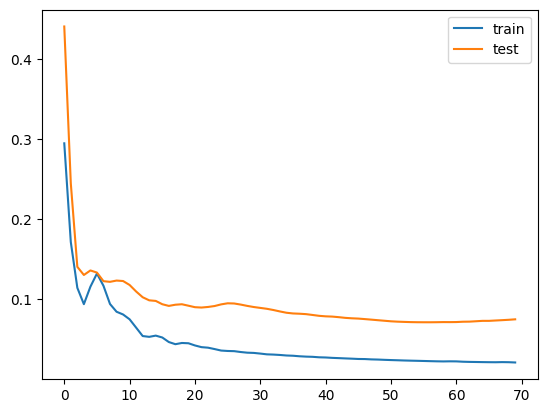

In [116]:
# Model fitting
history = model.fit(X_train, y_train, epochs=70, batch_size=128, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot training progression
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Predictions

In [117]:
# Get predicted values
yhat = model.predict(X_test)

# Reshaping back into 2D for inverse scaling
X_test_inv = X_test.reshape((X_test.shape[0], X_test.shape[2])) 

# Concatenate and Inverse Scaling
# Prediction
inv_yhat = concatenate((X_test_inv[:, 0:], yhat), axis=1) # Required to get back original scale
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, num_features*lag_steps] # Extract target_variable

# Validation
y_test_inv = y_test.reshape((len(y_test), 1))
inv_y = concatenate((X_test_inv[:, 0:], y_test_inv), axis=1) # Both arrays must have same dimensions
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, num_features*lag_steps]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


In [121]:
# Get RMSE
rmse = np.sqrt(mean_absolute_error(inv_y, inv_yhat))
print('Test MAE: %.3f' % rmse)

Test MAE: 3.056


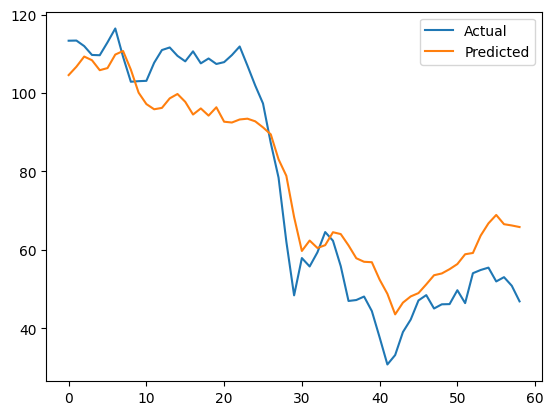

In [119]:
plt.plot(inv_y, label = 'Actual')
plt.plot(inv_yhat, label = 'Predicted')
plt.legend()
plt.show()